In [241]:
import sqlite3
import pandas as pd
import seaborn as sns
import math
from datetime import datetime
import plotly.express as px

In [242]:


# Connect to the SQLite database
conn = sqlite3.connect(r'data/caltrain_lat_long.db')

# Query the database and load the results into a pandas DataFrame
query = """
SELECT *
FROM train_locations
"""
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [243]:
df['stop_id'] = df['stop_id'].astype(int)

df['trip_id'] = df['trip_id'].astype(int)

In [244]:
def load_stops_data():
    stops_df = pd.read_csv('gtfs_data/stops.txt')
    stops_df = stops_df[stops_df['stop_id'].str.isnumeric()]
    return stops_df
def load_stop_times_data():
    stop_times_df = pd.read_csv('gtfs_data/stop_times.txt')
    return stop_times_df
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000  # Radius of Earth in meters
    return r * c

def has_train_arrived(train_lat, train_lon, stop_lat, stop_lon, threshold=100):
    distance = haversine(train_lat, train_lon, stop_lat, stop_lon)
    return distance <= threshold

In [245]:
stops_df = load_stops_data()
stop_times_df = load_stop_times_data()
stops_df['stop_id'] = stops_df['stop_id'].astype(int)

In [246]:
stops_df=stops_df.sort_values(by='stop_id')
stops_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_desc,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code
78,70011,70011,San Francisco Caltrain Station Northbound,37.776390,-122.394992,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
79,70012,70012,San Francisco Caltrain Station Southbound,37.776348,-122.394935,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
1,70021,70021,22nd Street Caltrain Station Northbound,37.757599,-122.391880,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
2,70022,70022,22nd Street Caltrain Station Southbound,37.757583,-122.392404,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
4,70031,70031,Bayshore Caltrain Station Northbound,37.709537,-122.401586,74634,NaN,NaN,0,bayshore,NaN,1,NaN


In [247]:
df2 = pd.merge(df,stop_times_df[['trip_id','stop_id','arrival_time']],on=['trip_id','stop_id'])
df2 = pd.merge(df2,stops_df[['stop_id','stop_name','parent_station','stop_lat','stop_lon']],on=['stop_id'])

In [248]:
# Apply the Haversine function to calculate distance for each row
df2['distance'] = df2.apply(lambda row: haversine(row['vehicle_lat'], row['vehicle_lon'], row['stop_lat'], row['stop_lon']), axis=1)


In [249]:
df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2['date'] = df2['timestamp'].dt.date

In [250]:
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t
# Normalize the arrival times


In [251]:
import pandas as pd
from datetime import datetime, time, timedelta


# Normalize the arrival times
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t

df2['arrival_time'] = df2['arrival_time'].apply(normalize_time)

# Convert 'timestamp' to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['arrival_time'] = pd.to_datetime(df2['arrival_time'], format='%H:%M:%S').dt.time

# Function to calculate time difference in minutes
def calculate_time_difference(time1, time2):
    datetime1 = datetime.combine(datetime.today(), time1)
    datetime2 = datetime.combine(datetime.today(), time2)
    time_diff = datetime2 - datetime1
    return time_diff.total_seconds() / 60  # Return the difference in minutes

# Find the minimum distance for each combination of trip_id, stop_id, and date
min_distances = df2.groupby(['trip_id', 'stop_id', 'date'])['distance'].min().reset_index()

# Merge the minimum distances back to the original dataframe
merged_df = pd.merge(df2, min_distances, on=['trip_id', 'stop_id', 'date', 'distance'])

arrival_times = merged_df.groupby(['trip_id', 'stop_id', 'date']).first().reset_index()
arrival_times = arrival_times[['trip_id', 'stop_id', 'date', 'timestamp']]
arrival_times.rename(columns={'timestamp': 'actual_arrival_time'}, inplace=True)

# Merge with the original dataframe to get the scheduled arrival time
comparison_df = pd.merge(arrival_times, df2[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])

# Calculate the delay in minutes
comparison_df['delay_minutes'] = comparison_df.apply(
    lambda row: calculate_time_difference( row['arrival_time'],row['actual_arrival_time'].time(),), axis=1
)
comparison_df.loc[comparison_df.delay_minutes > 500,'delay_minutes'] = 0.0
comparison_df.loc[comparison_df.delay_minutes < -100,'delay_minutes'] = 0.0
# Determine if the train is delayed
comparison_df['is_delayed'] = comparison_df['delay_minutes'] > 4

# Calculate the overall on-time performance based on unique trip counts
unique_trips = comparison_df.drop_duplicates(subset=['trip_id', 'stop_id', 'date'])
total_trips = len(unique_trips)
on_time_trips = len(unique_trips[unique_trips['is_delayed'] == False])
on_time_performance = (on_time_trips / total_trips) * 100

# print(comparison_df)
print(f"Total unique trips: {total_trips}")
print(f"On-time trips: {on_time_trips}")
print(f"On-time performance: {on_time_performance:.2f}%")


Total unique trips: 9658
On-time trips: 8067
On-time performance: 83.53%


In [252]:
df2['arrival_time']

0        15:52:00
1        15:50:00
2        16:03:00
3        17:05:00
4        15:52:00
           ...   
76308    17:42:00
76309    18:15:00
76310    17:19:00
76311    17:47:00
76312    18:11:00
Name: arrival_time, Length: 76313, dtype: object

In [253]:
df2.timestamp

0       2024-07-07 15:48:54
1       2024-07-07 15:48:54
2       2024-07-07 15:48:54
3       2024-07-07 15:48:54
4       2024-07-07 15:49:54
                ...        
76308   2024-07-17 17:42:10
76309   2024-07-17 17:42:10
76310   2024-07-17 17:42:10
76311   2024-07-17 17:42:10
76312   2024-07-17 17:42:10
Name: timestamp, Length: 76313, dtype: datetime64[ns]

<Axes: xlabel='delay_minutes', ylabel='Count'>

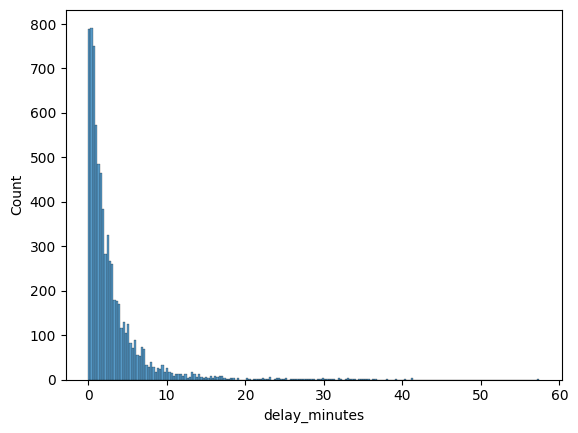

In [254]:
sns.histplot(data=unique_trips.loc[unique_trips.delay_minutes >=0],x='delay_minutes')

In [255]:
# test=df2.loc[(df2.date == datetime(2024, 7, 16).date()) & (df2.trip_id==306)]
# # Find the minimum distance for each combination of trip_id, stop_id, and date
# min_distances = test.groupby(['trip_id', 'stop_id', 'date'])['distance'].min().reset_index()

# # Merge the minimum distances back to the original dataframe
# merged_df = pd.merge(test, min_distances, on=['trip_id', 'stop_id', 'date', 'distance'])

# arrival_times = merged_df.groupby(['trip_id', 'stop_id', 'date']).first().reset_index()
# arrival_times = arrival_times[['trip_id', 'stop_id', 'date', 'timestamp']]
# arrival_times.rename(columns={'timestamp': 'actual_arrival_time'}, inplace=True)

# # Merge with the original dataframe to get the scheduled arrival time
# comparison_df = pd.merge(arrival_times, test[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])

# # Calculate the delay in minutes
# comparison_df['delay_minutes'] = comparison_df.apply(
#     lambda row: calculate_time_difference(row['actual_arrival_time'].time(), row['arrival_time']), axis=1
# )
# comparison_df.loc[comparison_df.delay_minutes > 500,'delay_minutes'] = 0.0
# comparison_df.loc[comparison_df.delay_minutes < -100,'delay_minutes'] = 0.0
# # Determine if the train is delayed
# comparison_df['is_delayed'] = comparison_df['delay_minutes'] > 4

# # Calculate the overall on-time performance based on unique trip counts
# unique_trips = comparison_df.drop_duplicates(subset=['trip_id', 'stop_id', 'date'])
# total_trips = len(unique_trips)
# on_time_trips = len(unique_trips[unique_trips['is_delayed'] == False])
# on_time_performance = (on_time_trips / total_trips) * 100

# # print(comparison_df)
# print(f"Total unique trips: {total_trips}")
# print(f"On-time trips: {on_time_trips}")
# print(f"On-time performance: {on_time_performance:.2f}%")

In [256]:
# comparison_df = pd.merge(arrival_times, test[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])
# comparison_df

In [257]:
# merged_df.head(20)

In [258]:
merged_df.apply(
    lambda row: calculate_time_difference(row['arrival_time'],row['timestamp'].time()), axis=1
)

0       -76.100000
1        -0.100000
2        -8.100000
3       -75.100000
4       -74.100000
           ...    
22804    -5.833333
22805     0.166667
22806    23.166667
22807    -4.833333
22808   -28.833333
Length: 22809, dtype: float64

In [259]:
min_distances

,trip_id,stop_id,date,distance
0,101,70021,2024-07-08,609.779650
1,101,70021,2024-07-10,580.331942
2,101,70021,2024-07-12,244.713606
3,101,70021,2024-07-15,586.642951
4,101,70021,2024-07-17,1885.479368
...,...,...,...,...
9653,712,70212,2024-07-10,646.884178
9654,712,70212,2024-07-11,180.822389
9655,712,70212,2024-07-12,104.743789
9656,712,70212,2024-07-15,1803.714142


In [260]:
df2.date[0] == datetime(2024, 7, 7).date()


True

In [261]:
datetime(2024, 7, 7).date()

datetime.date(2024, 7, 7)

In [262]:
unique_trips.loc[(unique_trips.delay_minutes >4) & (unique_trips.delay_minutes <=15),'delay_severity'] = 'Minor'
unique_trips.loc[(unique_trips.delay_minutes >15),'delay_severity'] = 'Major'

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\3806708418.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [263]:
unique_trips['delay_severity'].unique()

array([nan, 'Minor', 'Major'], dtype=object)

<Axes: xlabel='delay_severity'>

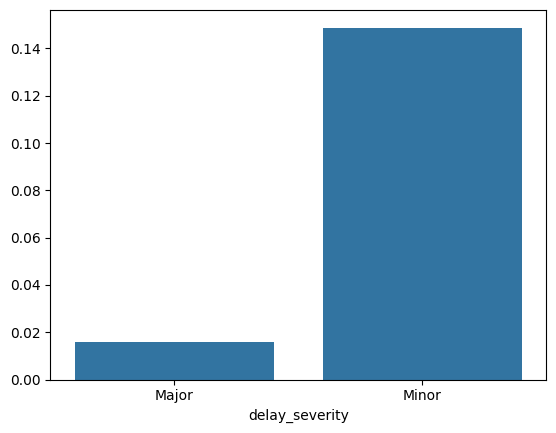

In [264]:
res = unique_trips.groupby('delay_severity').size() / total_trips
sns.barplot(res)

In [265]:
unique_trips['delay_severity'].fillna('On Time', inplace=True)

# Calculate percentage of delays by severity
delay_severity_counts = unique_trips['delay_severity'].value_counts(normalize=True) * 100
delay_severity_counts = delay_severity_counts.reset_index()
delay_severity_counts.columns = ['delay_severity', 'percentage']

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\2686362821.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\2686362821.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [266]:
# Create the bar plot using Plotly Express
fig = px.bar(delay_severity_counts, x='delay_severity', y='percentage', title="Percentage of Delayed Commutes by Severity",
             labels={'delay_severity': 'Delay Severity', 'percentage': 'Percentage'})
fig.show()

In [267]:
df3=unique_trips.copy()
df3.loc[df3.delay_minutes < 0,'delay_minutes'] =0

In [268]:
# day of week

In [269]:
# weekday vs weekend

In [270]:
def categorize_commute_time(timestamp):
    # Check if the day is a weekday (Monday=0, Sunday=6)
    if timestamp.weekday() >= 5:  # Saturday (5) and Sunday (6)
        return 'Weekend'
    
    morning_start = time(6, 0)
    morning_end = time(9, 0)
    evening_start = time(15, 30)
    evening_end = time(19, 30)
    
    commute_time = timestamp.time()
    
    if morning_start <= commute_time <= morning_end:
        return 'Morning'
    elif evening_start <= commute_time <= evening_end:
        return 'Evening'
    else:
        return 'Other'
unique_trips['commute_period'] =unique_trips['actual_arrival_time'].apply(categorize_commute_time)

# Filter for Morning and Evening commutes
filtered_trips = unique_trips[unique_trips['commute_period'].isin(['Morning', 'Evening'])]

# Calculate total trips for each commute period
total_commute_period_trips = filtered_trips.groupby('commute_period').size().reset_index(name='total_counts')

# Calculate counts of delays by commute period and severity
commute_delay_counts = filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

# Merge to get total counts for each commute period
commute_delay_counts = pd.merge(commute_delay_counts, total_commute_period_trips, on='commute_period')

# Calculate percentage of delays by commute period and severity
commute_delay_counts['percentage'] = (commute_delay_counts['counts'] / commute_delay_counts['total_counts']) * 100


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\3155030901.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

,commute_period,delay_severity,counts
0,Evening,Major,46
1,Evening,Minor,467
2,Evening,On Time,1711
3,Morning,Major,31
4,Morning,Minor,156
5,Morning,On Time,1476


In [272]:
commute_delay_counts

,commute_period,delay_severity,counts,total_counts,percentage
0,Evening,Major,46,2224,2.068345
1,Evening,Minor,467,2224,20.998201
2,Evening,On Time,1711,2224,76.933453
3,Morning,Major,31,1663,1.864101
4,Morning,Minor,156,1663,9.380637
5,Morning,On Time,1476,1663,88.755262


In [273]:
# morning, evening commutes 6-9a / 3:30-7:30p
unique_trips.loc[(unique_trips.date == datetime(2024, 7, 16).date()) & (unique_trips.trip_id==306)].head(50)

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
45816,306,70012,2024-07-16,2024-07-16 08:26:04,San Francisco Caltrain Station Southbound,san_francisco,08:25:00,1.066667,False,On Time,Morning
45907,306,70022,2024-07-16,2024-07-16 08:39:05,22nd Street Caltrain Station Southbound,22nd_street,08:30:00,9.083333,True,Minor,Morning
45975,306,70042,2024-07-16,2024-07-16 08:48:06,South San Francisco Caltrain Station Southbound,south_sf,08:40:00,8.100000,True,Minor,Morning
46020,306,70062,2024-07-16,2024-07-16 08:54:07,Millbrae Caltrain Station Southbound,place_MLBR,08:46:00,8.116667,True,Minor,Morning
46065,306,70112,2024-07-16,2024-07-16 09:01:10,Hillsdale Caltrain Station Southbound,hillsdale,08:55:00,6.166667,True,Minor,Other
46098,306,70122,2024-07-16,2024-07-16 09:07:10,Belmont Caltrain Station Southbound,belmont,08:59:00,8.166667,True,Minor,Other
46126,306,70142,2024-07-16,2024-07-16 09:12:11,Redwood City Caltrain Station Southbound,redwood_city,09:05:00,7.183333,True,Minor,Other
46161,306,70162,2024-07-16,2024-07-16 09:19:12,Menlo Park Caltrain Station Southbound,menlo_park,09:10:00,9.200000,True,Minor,Other
46185,306,70172,2024-07-16,2024-07-16 09:22:12,Palo Alto Caltrain Station Southbound,palo_alto,09:14:00,8.200000,True,Minor,Other
46201,306,70192,2024-07-16,2024-07-16 09:25:12,California Avenue Caltrain Station Southbound,california_ave,09:18:00,7.200000,True,Minor,Other


In [274]:
# morning, evening commutes 6-9a / 3:30-7:30p
unique_trips.sort_values(by='actual_arrival_time').tail(50)

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
48551,310,70172,2024-07-17,2024-07-17 17:14:06,Palo Alto Caltrain Station Southbound,palo_alto,17:14:00,0.100000,False,On Time,Evening
58267,413,70241,2024-07-17,2024-07-17 17:16:06,Santa Clara Caltrain Station Northbound,santa_clara,17:48:00,-31.900000,False,On Time,Evening
57442,412,70022,2024-07-17,2024-07-17 17:16:06,22nd Street Caltrain Station Southbound,22nd_street,17:15:00,1.100000,False,On Time,Evening
47964,309,70211,2024-07-17,2024-07-17 17:18:07,Mountain View Caltrain Station Northbound,mountain_view,16:40:00,38.116667,True,Major,Evening
18507,125,70041,2024-07-17,2024-07-17 17:18:07,South San Francisco Caltrain Station Northbound,south_sf,17:13:00,5.116667,True,Minor,Evening
58345,413,70261,2024-07-17,2024-07-17 17:18:07,San Jose Diridon Caltrain Station Northbound,sj_diridon,17:42:00,-23.883333,False,On Time,Evening
48568,310,70192,2024-07-17,2024-07-17 17:18:07,California Avenue Caltrain Station Southbound,california_ave,17:18:00,0.116667,False,On Time,Evening
20560,127,70231,2024-07-17,2024-07-17 17:19:07,Lawrence Caltrain Station Northbound,lawrence,17:07:00,12.116667,True,Minor,Evening
57162,411,70221,2024-07-17,2024-07-17 17:20:07,Sunnyvale Caltrain Station Northbound,sunnyvale,16:56:00,24.116667,True,Major,Evening
75370,710,70062,2024-07-17,2024-07-17 17:20:07,Millbrae Caltrain Station Southbound,place_MLBR,17:22:00,-1.883333,False,On Time,Evening


In [275]:
fig = px.histogram(unique_trips.loc[unique_trips.delay_minutes >=1],x='delay_minutes', color="commute_period",barmode='overlay',marginal="box", # or violin, rug
                   hover_data=unique_trips.columns)
fig.show()

In [276]:
unique_trips.date.unique()

array([datetime.date(2024, 7, 8), datetime.date(2024, 7, 10),
       datetime.date(2024, 7, 12), datetime.date(2024, 7, 15),
       datetime.date(2024, 7, 17), datetime.date(2024, 7, 16),
       datetime.date(2024, 7, 9), datetime.date(2024, 7, 11),
       datetime.date(2024, 7, 13), datetime.date(2024, 7, 14),
       datetime.date(2024, 7, 7)], dtype=object)

In [277]:
unique_trips.parent_station.unique()

array(['22nd_street', 'bayshore', 'south_sf', 'san_bruno', 'place_MLBR',
       'burlingame', 'san_mateo', 'hayward_park', 'hillsdale', 'belmont',
       'san_carlos', 'redwood_city', 'menlo_park', 'palo_alto',
       'california_ave', 'san_antonio', 'mountain_view', 'sunnyvale',
       'lawrence', 'santa_clara', 'sj_diridon', 'tamien', 'san_francisco',
       'college_park', 'broadway', 'capitol', 'blossom_hill',
       'morgan_hill', 'san_martin', 'gilroy'], dtype=object)

In [278]:
def clean_station_name(name):
    if name == 'place_MLBR':
        return 'Millbrae'
    name = name.replace('_', ' ')
    return name.title()
# Apply the cleaning function to parent_station names
unique_trips['parent_station'] = unique_trips['parent_station'].apply(clean_station_name)


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\832418268.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [279]:
(comparison_df['delay_minutes'] > 4) & (comparison_df['delay_minutes'] < 500)

0        False
1        False
2        False
3        False
4        False
         ...  
76308    False
76309    False
76310    False
76311    False
76312    False
Name: delay_minutes, Length: 76313, dtype: bool

In [280]:
import plotly.graph_objects as go
# Create a pivot table for the heatmap
# Create a pivot table for the heatmap
unique_trips.loc[unique_trips.delay_minutes < 0,'delay_minutes']=0
heatmap_data = unique_trips.pivot_table(index='trip_id', columns='stop_id', values='delay_minutes', aggfunc='mean', sort=False)
stop_id_to_parent_station = unique_trips[['stop_id', 'parent_station']].drop_duplicates().set_index('stop_id')['parent_station'].to_dict()

# Sort the columns of the pivot table explicitly
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
heatmap_data.columns = [stop_id_to_parent_station[stop_id] for stop_id in heatmap_data.columns]
heatmap_data.index=heatmap_data.index.astype(str)
# heatmap_data = heatmap_data.sort_index(axis=1)
# Create the heatmap using Plotly
fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis',

))

fig_heatmap.update_layout(
    title="Heatmap of Delays by Stop and Train Number",
    xaxis_title="Stop",
    yaxis_title="Train Number",
    height = 1000,
)

In [281]:
# Calculate the center point for the color scale
center = heatmap_data.mean().mean()

fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='RdBu_r',  # A diverging color scale
    hovertemplate='Train: %{y}<br>Station: %{x}<br>Delay: %{z:.1f} minutes<extra></extra>'
))

fig_heatmap.update_layout(
    title="Heatmap of Delays by Stop and Train Number",
    title_x=0.5,  # Center the title
    xaxis_title="Stop",
    yaxis_title="Train Number",
    xaxis_tickangle=-45,  # Rotate x-axis labels
    height=800,  # Adjust height
    width=1200,  # Make it wider
    margin=dict(l=50, r=50, t=80, b=100)  # Adjust margins
)

# Add annotations if needed
fig_heatmap.add_annotation(
    text="Negative values (blue) indicate early arrivals, positive (red) indicate delays",
    showarrow=False,
    x=0.5,
    y=-0.15,
    xref="paper",
    yref="paper"
)

# Optionally, update axis properties for better readability
fig_heatmap.update_xaxes(side="bottom", tickfont=dict(size=10))
fig_heatmap.update_yaxes(tickfont=dict(size=10))

fig_heatmap.show()

In [282]:
h.loc[h.trip_id=='309']

,trip_id,San Francisco,22Nd Street,22Nd Street,Bayshore,Bayshore,South Sf,South Sf,San Bruno,San Bruno,...,Tamien,Capitol,Capitol,Blossom Hill,Blossom Hill,Morgan Hill,Morgan Hill,San Martin,San Martin,Gilroy
81,309,NaN,7.554167,NaN,NaN,NaN,7.533333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
# scatter = go.Scatter(x=np.array(lon).flatten(),
#                      y=np.array(lat).flatten(),
#                      marker={'color': np.array(v).flatten(),
#                              'showscale': True},
#                      mode='markers')
# fig = go.FigureWidget(data=[scatter],
#                       layout={'xaxis': {'title': 'lon'},
#                               'yaxis': {'title': 'lat'}})
# fig

In [284]:
unique_trips.loc[unique_trips.trip_id==309]

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
47682,309,70021,2024-07-10,2024-07-10 17:53:25,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,18.416667,True,Major,Evening
47691,309,70021,2024-07-12,2024-07-12 17:40:32,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,5.533333,True,Minor,Evening
47700,309,70021,2024-07-15,2024-07-15 17:36:05,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,1.083333,False,On Time,Evening
47710,309,70021,2024-07-16,2024-07-16 17:40:11,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,5.183333,True,Minor,Evening
47718,309,70041,2024-07-10,2024-07-10 17:44:24,South San Francisco Caltrain Station Northbound,South Sf,17:26:00,18.400000,True,Major,Evening
...,...,...,...,...,...,...,...,...,...,...,...
48109,309,70261,2024-07-10,2024-07-10 16:04:36,San Jose Diridon Caltrain Station Northbound,Sj Diridon,16:21:00,0.000000,False,On Time,Evening
48121,309,70261,2024-07-12,2024-07-12 16:10:16,San Jose Diridon Caltrain Station Northbound,Sj Diridon,16:21:00,0.000000,False,On Time,Evening
48130,309,70261,2024-07-15,2024-07-15 16:09:40,San Jose Diridon Caltrain Station Northbound,Sj Diridon,16:21:00,0.000000,False,On Time,Evening
48140,309,70261,2024-07-16,2024-07-16 16:00:45,San Jose Diridon Caltrain Station Northbound,Sj Diridon,16:21:00,0.000000,False,On Time,Evening


In [285]:
# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# # Reset index to have date as a column
daily_summary = daily_summary.reset_index()
# # Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major',	'Minor','On Time'], var_name='Status', value_name='Percentage')
import plotly.express as px

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', title='Percentage of On Time and Delayed Trips per Day')

# Show the plot
fig.show()


In [286]:
daily_summary_melted

,date,Status,Percentage
0,2024-07-07,Major,NaN
1,2024-07-08,Major,4.215976
2,2024-07-09,Major,NaN
3,2024-07-10,Major,2.620456
4,2024-07-11,Major,NaN
5,2024-07-12,Major,1.256467
6,2024-07-13,Major,NaN
7,2024-07-14,Major,NaN
8,2024-07-15,Major,0.832702
9,2024-07-16,Major,1.510791


In [287]:
import pandas as pd
import plotly.express as px

# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# Reset index to have date as a column
daily_summary = daily_summary.reset_index()

# Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major', 'Minor', 'On Time'], var_name='Status', value_name='Percentage')

# Define the order of the Status items
status_order = ['On Time', 'Minor Delay', 'Major Delay']
daily_summary_melted.loc[daily_summary_melted.Status == 'Major','Status']='Major Delay'
daily_summary_melted.loc[daily_summary_melted.Status == 'Minor','Status']='Minor Delay'
# Define custom colors for each Status
status_colors = {
    'On Time': '#00CC96',
    'Minor Delay': '#FECB52',
    'Major Delay': '#EF553B'
}

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', 
             title='On-time performance by date',
             category_orders={'Status': status_order},
             color_discrete_map=status_colors,labels={'date': 'Date', 'percentage': 'Percentage','Minor':'Minor Delay'})

# Show the plot
fig.show()



In [304]:
import pandas as pd
import plotly.express as px

# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# Reset index to have date as a column
daily_summary = daily_summary.reset_index()

# Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major', 'Minor', 'On Time'], var_name='Status', value_name='Percentage')
daily_summary_melted.Percentage=daily_summary_melted.Percentage.fillna(0)
# Define the order of the Status items
status_order = ['On Time', 'Minor Delay', 'Major Delay']
daily_summary_melted.loc[daily_summary_melted.Status == 'Major','Status']='Major Delay'
daily_summary_melted.loc[daily_summary_melted.Status == 'Minor','Status']='Minor Delay'
# Define custom colors for each Status
status_colors = {
    'On Time': '#00CC96',
    'Minor Delay': '#FECB52',
    'Major Delay': '#EF553B'
}

# Create the stacked bar plot
fig = px.line(daily_summary_melted, x='date', y='Percentage', color='Status', markers=True,
             title='On-time performance by date',
             category_orders={'Status': status_order},
             color_discrete_map=status_colors,labels={'date': 'Date', 'percentage': 'Percentage','Minor':'Minor Delay'})

# Show the plot
fig.show()



In [292]:
daily_summary_melted

,date,Status,Percentage
0,2024-07-07,Major Delay,NaN
1,2024-07-08,Major Delay,4.215976
2,2024-07-09,Major Delay,NaN
3,2024-07-10,Major Delay,2.620456
4,2024-07-11,Major Delay,NaN
5,2024-07-12,Major Delay,1.256467
6,2024-07-13,Major Delay,NaN
7,2024-07-14,Major Delay,NaN
8,2024-07-15,Major Delay,0.832702
9,2024-07-16,Major Delay,1.510791


In [289]:
unique_trips

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
0,101,70021,2024-07-08,2024-07-08 05:55:19,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,0.316667,False,On Time,Other
6,101,70021,2024-07-10,2024-07-10 05:59:41,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,4.683333,True,Minor,Other
11,101,70021,2024-07-12,2024-07-12 05:57:58,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,2.966667,False,On Time,Other
17,101,70021,2024-07-15,2024-07-15 05:57:29,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,2.483333,False,On Time,Other
22,101,70021,2024-07-17,2024-07-17 05:54:18,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,0.000000,False,On Time,Other
...,...,...,...,...,...,...,...,...,...,...,...
76270,712,70212,2024-07-10,2024-07-10 19:00:02,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,5.033333,True,Minor,Evening
76281,712,70212,2024-07-11,2024-07-11 19:01:06,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,6.100000,True,Minor,Evening
76289,712,70212,2024-07-12,2024-07-12 18:56:56,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,1.933333,False,On Time,Evening
76298,712,70212,2024-07-15,2024-07-15 18:54:17,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,0.000000,False,On Time,Evening


In [290]:
unique_trips['hour'] = pd.to_datetime(unique_trips['actual_arrival_time']).dt.hour
# Calculate average delay by hour
hourly_delays = unique_trips.groupby('hour')['delay_minutes'].mean().reset_index()

# Create the histogram
fig_hourly_delays = px.bar(hourly_delays, x='hour', y='delay_minutes',
                           labels={'hour': 'Hour of Day', 'delay_minutes': 'Average Delay (minutes)'},
                           title='Average Delay by Hour of Day')

# Customize the layout
fig_hourly_delays.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

# Add a horizontal line for the overall average delay
overall_avg_delay = unique_trips['delay_minutes'].mean()
fig_hourly_delays.add_hline(y=overall_avg_delay, line_dash="dash", line_color="red",
                            annotation_text=f"Overall Average: {overall_avg_delay:.2f} min",
                            annotation_position="bottom right")

# Ensure x-axis shows all hours from 0 to 23
fig_hourly_delays.update_xaxes(range=[-0.5, 23.5])

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\1884667102.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [291]:
best_train=unique_trips.groupby('trip_id')['delay_minutes'].mean().reset_index()
best_train_delay_minutes = float(best_train.sort_values(by='delay_minutes').reset_index(drop=True).iloc[0,1])
best_train = int(best_train.sort_values(by='delay_minutes').reset_index(drop=True).iloc[0,0])
worst_train=unique_trips.groupby('trip_id')['delay_minutes'].mean().reset_index()
worst_train_delay_minutes = float(worst_train.sort_values(by='delay_minutes',ascending=False).reset_index(drop=True).iloc[0,1])
worst_train = int(worst_train.sort_values(by='delay_minutes',ascending=False).reset_index(drop=True).iloc[0,0])
best_stop=unique_trips.groupby('stop_id')['delay_minutes'].mean().reset_index()
best_stop_delay_minutes = float(best_stop.sort_values(by='delay_minutes').reset_index(drop=True).iloc[0,1])
best_stop = int(best_stop.sort_values(by='delay_minutes').reset_index(drop=True).iloc[0,0])
best_stop=unique_trips.loc[unique_trips.stop_id==best_stop,'stop_name'].reset_index(drop=True).iloc[0]
worst_stop=unique_trips.groupby('stop_id')['delay_minutes'].mean().reset_index()
worst_stop_delay_minutes = float(worst_stop.sort_values(by='delay_minutes',ascending=False).reset_index(drop=True).iloc[0,1])
worst_stop = int(worst_stop.sort_values(by='delay_minutes',ascending=False).reset_index(drop=True).iloc[0,0])
worst_stop=unique_trips.loc[unique_trips.stop_id==worst_stop,'stop_name'].reset_index(drop=True).iloc[0]